In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, ConfusionMatrix
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from PIL import Image

Transformacje obrazów: zmiana rozmiaru

In [2]:
resizing = 128
transform = transforms.Compose([
    transforms.Resize((resizing, resizing)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a tensor
])

# Experiment

In [3]:
experiment_ID = "AS_06"

## Wczytanie datasetu

In [4]:
dataset = datasets.ImageFolder(root='/kaggle/input/umpxray002', transform=transform)
#test data!!!
dataset_test = datasets.ImageFolder(root='/kaggle/input/ump-xray-test-set/ump_xray_test',transform=transform)

# To see some statistics or details
print(f"Total number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")
print("Number of rows in dataset wszystkich wierszy w datasecie: ", len(dataset))
#test data

print("Number of rows in dataset_test wszystkich wierszy w datasecie: ", len(dataset_test))

Total number of classes: 15
Class names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Number of rows in dataset wszystkich wierszy w datasecie:  21045
Number of rows in dataset_test wszystkich wierszy w datasecie:  3783


## Podział na podzbiory

In [5]:
labels = np.array([label for _, label in dataset.samples])
test_size = 0.3
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))
train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)

print("Number of index in train : ",len(train_idx))
print("Number of index in val: ", len(val_idx))
print(f"Number of rows in train set: {len(train_set)} rows")
print(f"Number of rows in val set: {len(val_set)} rows")

Number of index in train :  14731
Number of index in val:  6314
Number of rows in train set: 14731 rows
Number of rows in val set: 6314 rows


## Loadery

In [9]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
#test data!
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
training_loader = train_loader 
validation_loader = val_loader

## Obsługa GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Definicja modelu

In [12]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        # 3 x 128 x 128
        self.conv = nn.Sequential(      
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            # 16 x 128, 128
            nn.ReLU(),
            # 16 x 128, 128
            nn.MaxPool2d(kernel_size=2),
            # 16 x 64 x 64
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            # 32 x 64 x 64
            nn.ReLU(),
            # 32 x 64 x 64
            nn.MaxPool2d(kernel_size=2),           
            # 32 x 32 x 32
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # 64 x 32 x 32
            nn.ReLU(),
            # 64 x 32 x 32
            nn.MaxPool2d(kernel_size=8),           
            # 64 x 4 x 4
            )
        
        self.clf = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 15)
        )
        
    def forward(self, x):
        feature_maps = self.conv(x)
        feature_maps = feature_maps.view(-1, 64*4*4)
        logits = self.clf(feature_maps)
        
        return logits
    
model = TinyCNN().to(device)
    

## Informacje o modelu

In [14]:
model

TinyCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=15, bias=True)
  )
)

In [15]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 556079


## Optymalizator

In [16]:
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [17]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)

## Pętla treningowa

In [18]:
from ignite.metrics import Metric
from ignite.exceptions import NotComputableError

class LogRawResults(Metric):

    def __init__(self, output_transform=lambda x: x, device="cpu"):
        self.outputs = []
        self.trues = []
        super(LogRawResults, self).__init__(output_transform=output_transform, device=device)

    def reset(self):
        self.outputs = []        
        self.trues = []
        super(LogRawResults, self).reset()

    def update(self, output):
        out, y = output[0].detach().cpu().numpy(), output[1].detach().cpu().numpy()
        
        self.outputs.append(out)
        self.trues.append(y)        

    def compute(self):
        outputs = np.concatenate(self.outputs, 0)
        trues = np.concatenate(self.trues, 0)
        
        return {
            'outputs': outputs,
            'trues': trues
        }
        

trainer = create_supervised_trainer(model, optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion),
    'logs': LogRawResults(),
    'cm':ConfusionMatrix(num_classes=15)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [19]:
@trainer.on(Events.ITERATION_COMPLETED(every=2))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")
    

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(training_loader)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")
    df = pd.DataFrame(metrics['logs']['outputs'])
    print('Adding trues')
    df['true'] = metrics['logs']['trues']
    df.to_csv(f'train_logs_{trainer.state.epoch:04}.csv', index=False)    


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(validation_loader)
    metrics = val_evaluator.state.metrics
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")
    df = pd.DataFrame(metrics['logs']['outputs'])    
    df['true'] = metrics['logs']['trues']
    df.to_csv(f'val_logs_{trainer.state.epoch:04}.csv', index=False)  

In [20]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(training_loader)  # Run evaluator on train loader
    metrics = train_evaluator.state.metrics  # Access metrics from the state of the evaluator
    train_loss = metrics['loss']
    train_accuracy = metrics['accuracy']
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Accuracy: {train_accuracy:.2f} Loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(validation_loader)  # Run evaluator on test loader
    metrics = val_evaluator.state.metrics  # Access metrics from the state of the evaluator
    test_loss = metrics['loss']
    test_accuracy = metrics['accuracy']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Accuracy: {test_accuracy:.2f} Loss: {test_loss:.2f}")

In [21]:
#confusion matrix for training set
@trainer.on(Events.COMPLETED)
def train_log_confusion_matrix(trainer):
    train_evaluator.run(training_loader)
    metrics = train_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
               'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 
               'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
    fig, ax = plt.subplots(figsize=(15,15))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix for train set') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)
    
    filename_cm = f"{experiment_ID}_conf_matrix_train_set.jpg"
    plt.savefig(filename_cm)

In [22]:
#confusion matrix for validation set
@trainer.on(Events.COMPLETED)
def val_log_confusion_matrix(trainer):
    val_evaluator.run(validation_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
               'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 
               'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
    fig, ax = plt.subplots(figsize=(15,15))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix for valid set') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)
    
    filename_cm = f"{experiment_ID}_conf_matrix_val_set.jpg"
    plt.savefig(filename_cm)

In [23]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

Epoch[1], Iter[2] Loss: 2.68
Epoch[1], Iter[4] Loss: 2.64
Epoch[1], Iter[6] Loss: 2.51
Epoch[1], Iter[8] Loss: 2.37
Epoch[1], Iter[10] Loss: 2.11
Epoch[1], Iter[12] Loss: 2.11
Epoch[1], Iter[14] Loss: 2.31
Epoch[1], Iter[16] Loss: 2.31
Epoch[1], Iter[18] Loss: 2.27
Epoch[1], Iter[20] Loss: 2.34
Epoch[1], Iter[22] Loss: 2.14
Epoch[1], Iter[24] Loss: 2.31
Epoch[1], Iter[26] Loss: 2.44
Epoch[1], Iter[28] Loss: 2.50
Epoch[1], Iter[30] Loss: 2.29
Epoch[1], Iter[32] Loss: 2.27
Epoch[1], Iter[34] Loss: 2.15
Epoch[1], Iter[36] Loss: 2.09
Epoch[1], Iter[38] Loss: 2.20
Epoch[1], Iter[40] Loss: 2.35
Epoch[1], Iter[42] Loss: 2.22
Epoch[1], Iter[44] Loss: 1.84
Epoch[1], Iter[46] Loss: 2.20
Epoch[1], Iter[48] Loss: 2.36
Epoch[1], Iter[50] Loss: 2.27
Epoch[1], Iter[52] Loss: 2.49
Epoch[1], Iter[54] Loss: 2.22
Epoch[1], Iter[56] Loss: 2.45
Epoch[1], Iter[58] Loss: 2.13
Epoch[1], Iter[60] Loss: 2.20
Epoch[1], Iter[62] Loss: 1.91
Epoch[1], Iter[64] Loss: 2.11
Epoch[1], Iter[66] Loss: 2.10
Epoch[1], Iter

State:
	iteration: 9220
	epoch: 20
	epoch_length: 461
	max_epochs: 20
	output: 2.7613208293914795
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

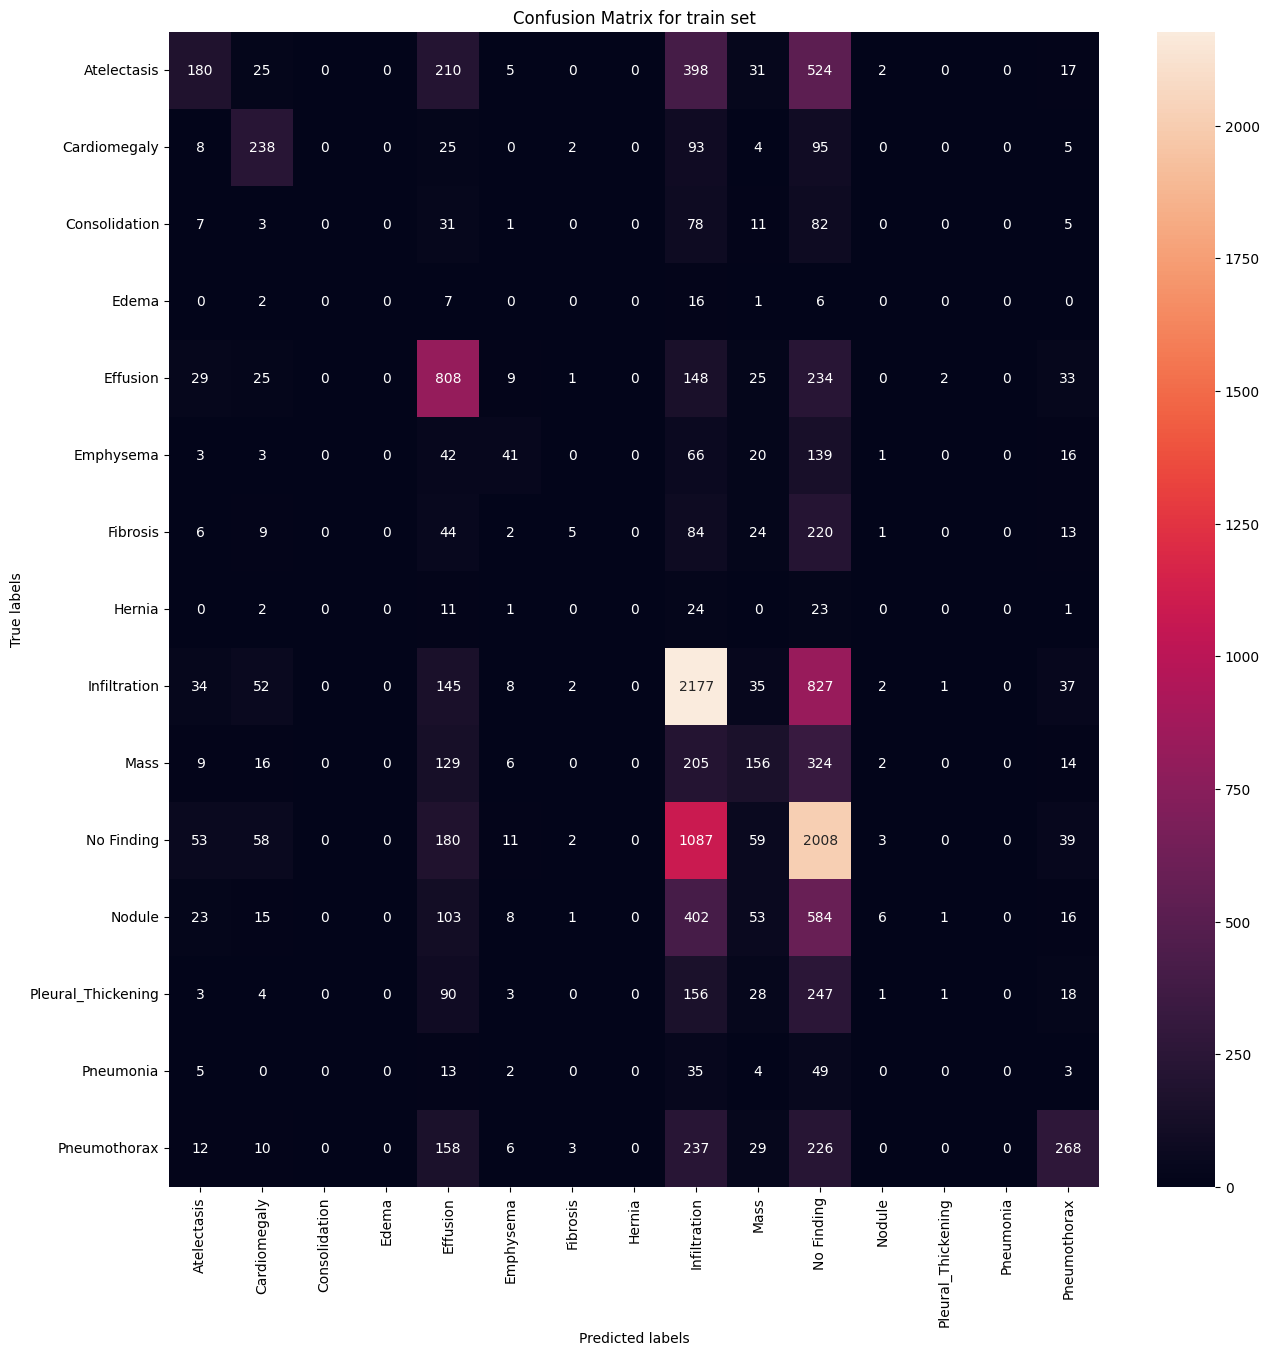

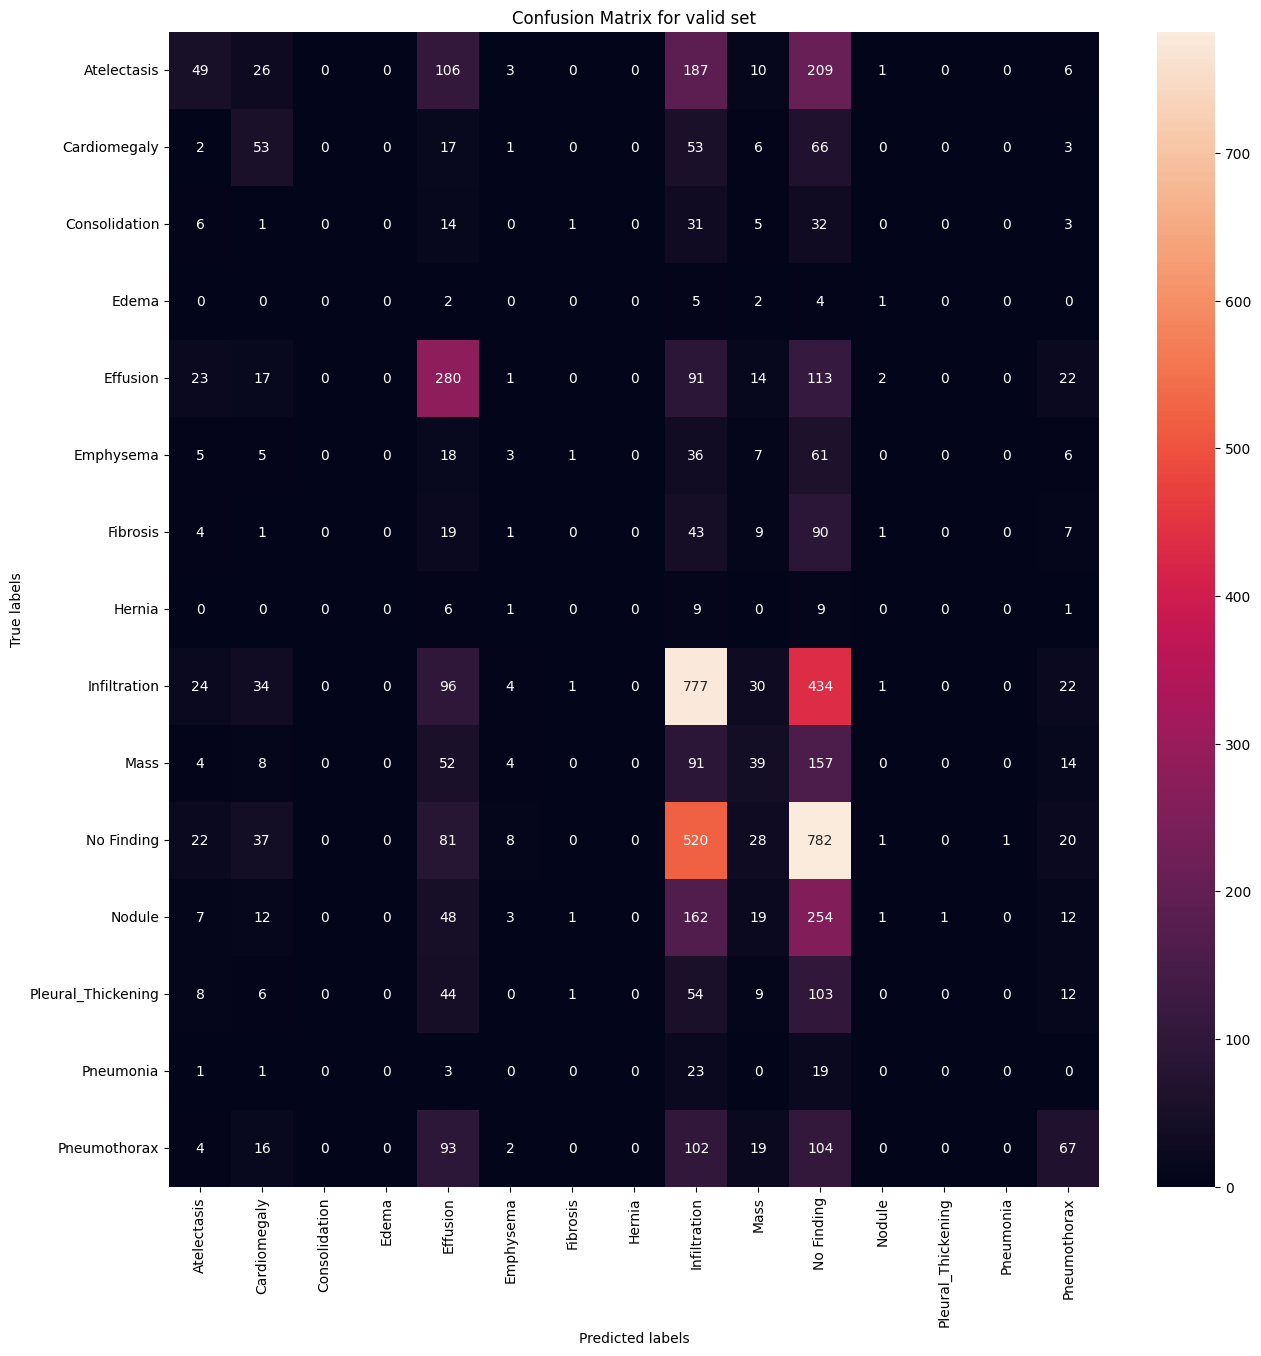

In [24]:
trainer.run(training_loader, max_epochs=20)

In [25]:
#list of scores needed for plot
print(f"Average visible loss function for train: {np.average(train_losses)}.")
print(f"Average visible loss function for test: {np.average(test_losses)}.")
print(f"Average visible accuracies for train: {np.average(train_accuracies)}.")
print(f"Average visible accuracies for test: {np.average(test_accuracies)}." )


Average visible loss function for train: 1.9798233741769056.
Average visible loss function for test: 2.079763773645371.
Average visible accuracies for train: 0.3290849229515987.
Average visible accuracies for test: 0.2990734874881217.


In [26]:
print(f"Accuracy for training set: {train_evaluator.state.metrics['accuracy']}.")
print(f"Accuracy for validation set: {val_evaluator.state.metrics['accuracy']}.")

Accuracy for training set: 0.39970131016224286.
Accuracy for validation set: 0.32483370288248337.


## Generowanie pliku do umieszcznia w raporcie

In [27]:
allocated_memory = torch.cuda.memory_allocated()
GPU_used = round(allocated_memory / 1024**3, 2)
print(f"{experiment_ID} GPU Memory Allocated: {allocated_memory / 1024**3:.2f} GB")
GPU_used

AS_06 GPU Memory Allocated: 0.02 GB


0.02

In [28]:
# nazwa pliku powinna zawierać numer eksperymentu - zmienna experiment_ID
report = {'experiment_ID': experiment_ID,
          'Test size' : test_size,
          'Image resizing' : resizing,
          'Batch size': batch_size,
          'Device' : device,
          'CNN parameters' : model,
          'Model' : optimizer,
          'Criterion' : criterion,
          'Number of params':total_params, 
          'Learning rate' : lr,
          'Train accuracy' : train_evaluator.state.metrics['accuracy'],
          'Validation acuracy' : val_evaluator.state.metrics['accuracy'],
          'Loss_value': [trainer.state.output],
          'Number_of_epochs': [trainer.state.epoch],
          'GPU: ': GPU_used}
report = pd.DataFrame(report)
#report.to_csv('report.csv', index=False)
filename_report = f"{experiment_ID}_report.csv"
report.to_csv(filename_report, index=False)

In [29]:
trainer.state.output

2.7613208293914795

## Wizualizacje

In [30]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, experiment_ID):
    # Determine the number of epochs from the length of the provided lists
    epochs_train = len(train_losses)
    epochs_test = len(test_losses)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs_train), train_losses, label='Train Loss')
    plt.plot(range(epochs_test), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs_train), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs_test), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    
    plt.suptitle(f"Experiment: {experiment_ID}")
    filename_loss = f"{experiment_ID}_loss_function.jpg"
    filename_accuracy = f"{experiment_ID}_accuracy.jpg"
    plt.savefig(filename_loss)
    plt.savefig(filename_accuracy)
    plt.show()

In [31]:
#list of scores needed for plot
#print(f"List of loss functions for train:{train_losses}.")
#print(f"List of loss functions for test: {test_losses}." )
#print(f"List of accuracies for train{train_accuracies}.")
#print(f"List of accuracies for test{test_accuracies}." )

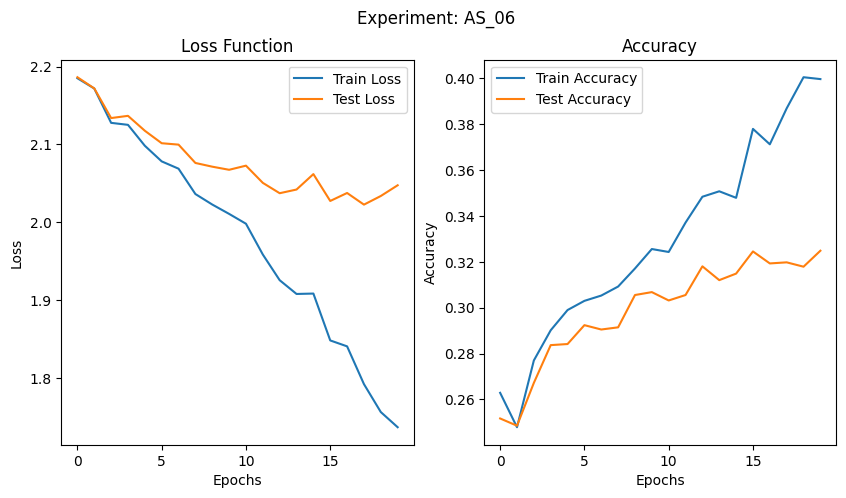

In [32]:
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies,  experiment_ID)

# Generowanie ROC

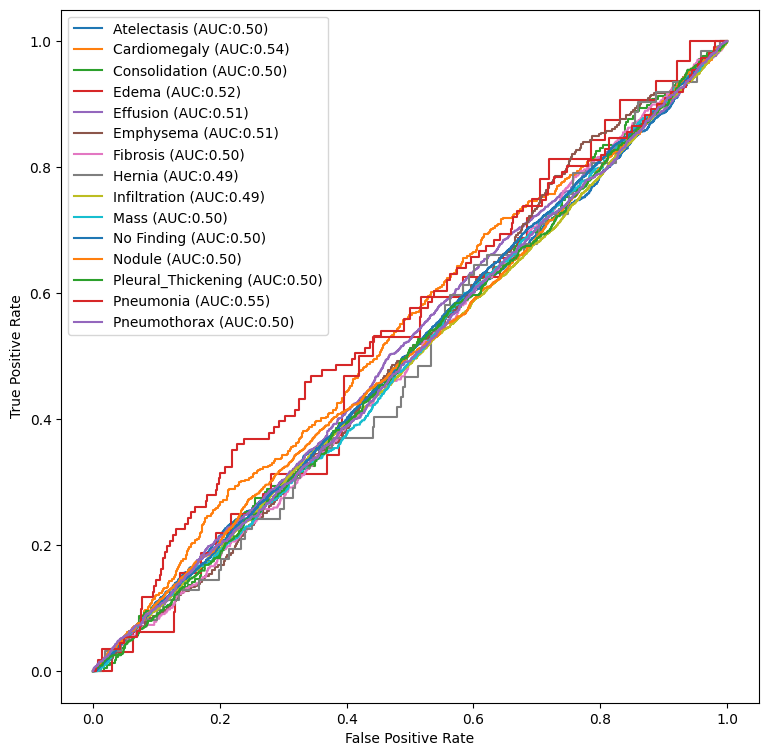

In [33]:
from sklearn.preprocessing import label_binarize 
from sklearn.metrics import roc_curve, auc

def predict_function(engine, batch):
    model.eval()
    with torch.no_grad():
        inputs, labels = batch
        inputs = inputs.to(device)  # device could be 'cuda' or 'cpu'
        output = model(inputs)
        probas = F.softmax(output, dim=1)
        return probas
    
predictor = Engine(predict_function)
predictions = []
@predictor.on(Events.ITERATION_COMPLETED)
def store_predictions(engine):
    pred= engine.state.output
    predictions.extend(pred.cpu().numpy())  # Assuming you want to move predictions to CPU
    
predictor.run(training_loader)

predictions = np.array(predictions)
    
subsets = {
    "train_set": train_set
    ,"val_set": val_set
    }

def wykres_roc_curve(subset_string, predictions):
    subset = train_set #subsets[subset_string]
    targets_subset = np.array([dataset.targets[index] for index in subset.indices])
    binarized_targets = label_binarize(targets_subset, classes=np.arange(len(dataset.classes)))
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, c_label) in enumerate(dataset.classes):
        fpr, tpr, thresholds = roc_curve(binarized_targets[:,idx], predictions[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.savefig(f"{experiment_ID}_roc_curve_{subset_string}.jpg")

wykres_roc_curve("train_set", predictions)

## Generowanie surowych wyników

In [34]:
def predict_function(engine, batch):
    model.eval()
    with torch.no_grad():
        inputs, labels = batch
        inputs = inputs.to(device)  # device could be 'cuda' or 'cpu'
        output = model(inputs)
        probas = F.softmax(output, dim=1)
        return probas
    
predictor = Engine(predict_function)
predictions = []
@predictor.on(Events.ITERATION_COMPLETED)
def store_predictions(engine):
    pred= engine.state.output
    predictions.extend(pred.cpu().numpy())  # Assuming you want to move predictions to CPU
    
predictor.run(test_loader)

predictions = np.array(predictions)

In [35]:
predictions.shape

(3783, 15)

In [36]:
filename_results = f"{experiment_ID}_results.csv"
pd.DataFrame(predictions, columns =dataset.classes).to_csv(filename_results)